<a href="https://www.kaggle.com/code/aisuko/the-full-model-building-process?scriptVersionId=136827315" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### Working with data

PyTorch has two primitives to wotk with data:
- `torch.utils.data.DataLoader`
- `torch.utils.data.Dataset`

`Dataset` stores the samples and their corresponding lables, and `DataLoader` wraps an iterable arounf the `Dataset`.

In [1]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
Note: you may need to restart the kernel to use updated packages.


In [2]:
# check the paltform, Apple Silicon or Linux
import os, platform

torch_device="cpu"

if 'kaggle' in os.environ.get('KAGGLE_URL_BASE','localhost'):
    torch_device = 'cuda'
else:
    torch_device = 'mps' if platform.system() == 'Darwin' else 'cpu'

In [3]:
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

In [4]:
torch_device

'cuda'

In [5]:
%matplotlib inline
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

PyTorch offers domain-specific libraries usch as `TorchText`, `TorchVision`, and `TorchAudio`, all of whihc include datasets. For this tutorial, we will be using a TorchVision dataset.

The `torchvision.datasets` module contains `Dataset` objects for many real-world vision data like CIFAR and COCO. In thie tutorial, we'll use the `FashionMNIST` dataset. Every TorchVision `Dataset` includes two arguments:
- `transform`: modifies the samples
- `target_transform`: modifies the labels

In [6]:
# Download training data from open datasets
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)


100%|██████████| 26421880/26421880 [00:01<00:00, 17749033.40it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 303060.06it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5466745.61it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 24818709.19it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



We pass the `Dataset` as an argument to `DataLoader`. This wraps an iterable over our dataset, and supports automatic batching, sampling, shuffing and multiprocess data loading. Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


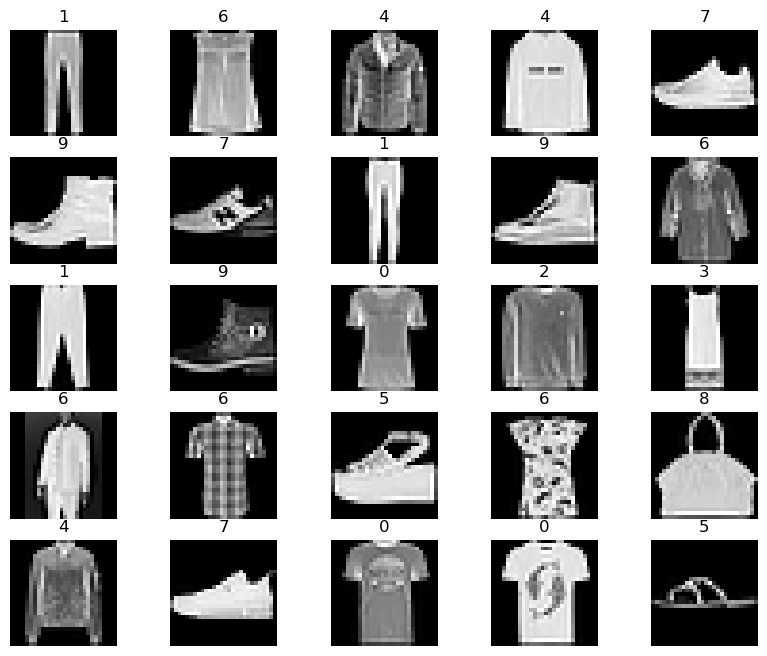

In [7]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

# Display sample data
figure = plt.figure(figsize=(10,8))
cols, rows =5,5
for i in range(1, cols*rows+1):
    idx = torch.randint(len(test_data), size=(1,)).item()
    img, label = test_data[idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Creating models

To define a neural network in PyTorch, we create a class that inherits from `nn.Module`. We define the layers of the network in the `__init__` function and specify how data will pas through the network in the `forward` function. To accelerate operations int he neural network, we move it to the GPU if available.

In [8]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(torch_device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)


### Optimizing the Model Parameters

To train a model, we need a `loss` funciton and an `optimizer`. We'll be using `nn.CrossEntropyLoss` for loss and `Stochastic Gradient Descent` for optimization.

In [9]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In a single training loop, the model makes predicitons on the training dataset (fed to it in batches), and back-propagates the prediction error to adjust the model's parameters.

In [10]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(torch_device), y.to(torch_device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

We can also check the model's performance against the test dataset to ensure it is learning.

In [11]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(torch_device), y.to(torch_device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

The training process is conducted over several iterations (epochs). During each epoch, the model learns parameters to make better predictions. We print the model's accuracy and loss at each epoch;we'd like to see the accuracy increase and the loss decrease with every epoch.

In [12]:
epochs =15
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model)
print("Done!")

Epoch 1
-------------------------------
loss: 2.305272  [    0/60000]
loss: 2.298108  [ 6400/60000]
loss: 2.288140  [12800/60000]
loss: 2.291547  [19200/60000]
loss: 2.277083  [25600/60000]
loss: 2.259001  [32000/60000]
loss: 2.283645  [38400/60000]
loss: 2.259866  [44800/60000]
loss: 2.252007  [51200/60000]
loss: 2.256436  [57600/60000]
Test Error: 
 Accuracy: 33.8%, Avg loss: 0.035343 

Epoch 2
-------------------------------
loss: 2.245766  [    0/60000]
loss: 2.237972  [ 6400/60000]
loss: 2.221499  [12800/60000]
loss: 2.258131  [19200/60000]
loss: 2.207806  [25600/60000]
loss: 2.173289  [32000/60000]
loss: 2.241191  [38400/60000]
loss: 2.187254  [44800/60000]
loss: 2.180116  [51200/60000]
loss: 2.199511  [57600/60000]
Test Error: 
 Accuracy: 35.2%, Avg loss: 0.034299 

Epoch 3
-------------------------------
loss: 2.164534  [    0/60000]
loss: 2.153685  [ 6400/60000]
loss: 2.124863  [12800/60000]
loss: 2.212119  [19200/60000]
loss: 2.102858  [25600/60000]
loss: 2.051462  [32000/600

The accuracy will initially not be very good(that's OK). Try running the loop got more `epochs` ot adjusting the `learning rate` to a bigger number. It might also be the case that the model configuration we chose might note be the optimal one for this kind of problem(it isn't). Later courses will devle more into the model shapes that work for vision problems.

### Saving Models

A common way to save a model is to serialize the internal state dictionary (containing the model parameters).

In [13]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


### Loading Models
The process for loading a model includes re-creating the model structure and loading the state dictionary into it.

In [14]:
model = NeuralNetwork().to(torch_device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

This model can now be used to make predicitons.

In [15]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle Boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
x = x.to(torch_device)
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle Boot", Actual: "Ankle Boot"


### Summary

We built an image recognition model taht could classify images such as: T-sgirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, and Ankle boots.